In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Objetivo

Prever se o cliente se inscreveu em um depósito a prazo: variável `y` binária "yes" e "no"

In [2]:
bank = pd.read_csv("../data/bank-additional-full.csv", sep=";")

In [3]:
bank_train, bank_test = train_test_split(bank, test_size=0.2, random_state=42)

In [4]:
bank_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
12556,40,blue-collar,married,basic.9y,unknown,yes,no,telephone,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
35451,31,admin.,married,university.degree,no,no,no,cellular,may,mon,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
30592,59,retired,married,basic.4y,no,no,no,cellular,may,mon,...,6,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
17914,43,housemaid,divorced,basic.9y,no,yes,no,cellular,jul,tue,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
3315,39,admin.,single,high.school,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,58,retired,married,professional.course,unknown,no,no,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11284,37,management,married,university.degree,no,no,no,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
38158,35,admin.,married,high.school,no,yes,no,cellular,oct,thu,...,1,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes
860,40,management,married,university.degree,no,yes,no,telephone,may,wed,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


In [5]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 12556 to 15795
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32950 non-null  object 
 2   marital         32950 non-null  object 
 3   education       32950 non-null  object 
 4   default         32950 non-null  object 
 5   housing         32950 non-null  object 
 6   loan            32950 non-null  object 
 7   contact         32950 non-null  object 
 8   month           32950 non-null  object 
 9   day_of_week     32950 non-null  object 
 10  duration        32950 non-null  int64  
 11  campaign        32950 non-null  int64  
 12  pdays           32950 non-null  int64  
 13  previous        32950 non-null  int64  
 14  poutcome        32950 non-null  object 
 15  emp.var.rate    32950 non-null  float64
 16  cons.price.idx  32950 non-null  float64
 17  cons.conf.idx   32950 non-n

In [6]:
bank_train.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.017420,257.746313,2.572959,962.745341,0.172989,0.083105,93.576835,-40.514574,3.622698,5167.094049
std,10.435842,259.459863,2.778138,186.248245,0.492992,1.570011,0.579157,4.622683,1.733735,72.354625
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
num_columns = bank_train.select_dtypes(exclude="object").columns

In [9]:
bank_train.groupby("y")[num_columns].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.914789,220.618123,2.641409,-0.894443,0.132501,0.250535,93.604539,-40.605560,3.813398,5176.281860
yes,40.827530,550.813495,2.032659,0.436437,0.492578,-1.238489,93.358157,-39.796383,2.117429,5094.571093


(<AxesSubplot:xlabel='count', ylabel='job'>,
 <AxesSubplot:xlabel='mean', ylabel='job'>)

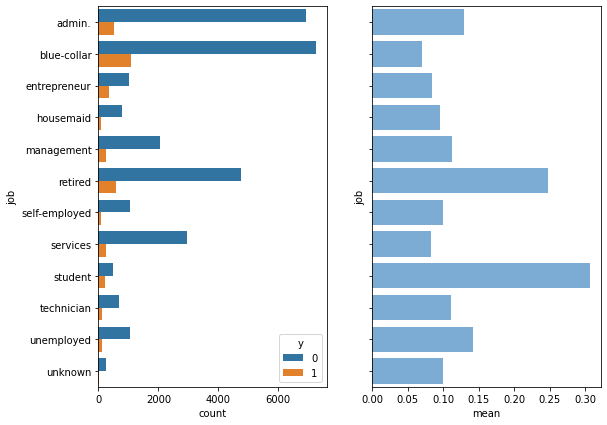

In [10]:
def plot_cat(df, cat):
    df_copy = df.copy()
    df_copy["y"] = df_copy["y"].apply(lambda x: 1 if x == "yes" else 0)
    df_prc = df_copy.groupby(cat)["y"].agg({"count", "mean"}).reset_index()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 7), sharey=True)
    sns.countplot(y=cat, hue="y", data=df_copy, ax=ax1)
    sns.barplot(x="mean", y=cat, color="#6daee2", data=df_prc, ax=ax2)
    return ax1, ax2
    
plot_cat(bank_train, "job")

(<AxesSubplot:xlabel='count', ylabel='marital'>,
 <AxesSubplot:xlabel='mean', ylabel='marital'>)

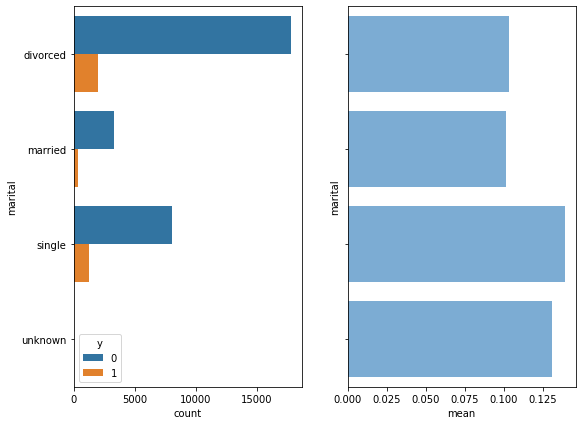

In [11]:
plot_cat(bank_train, "marital")

(<AxesSubplot:xlabel='count', ylabel='education'>,
 <AxesSubplot:xlabel='mean', ylabel='education'>)

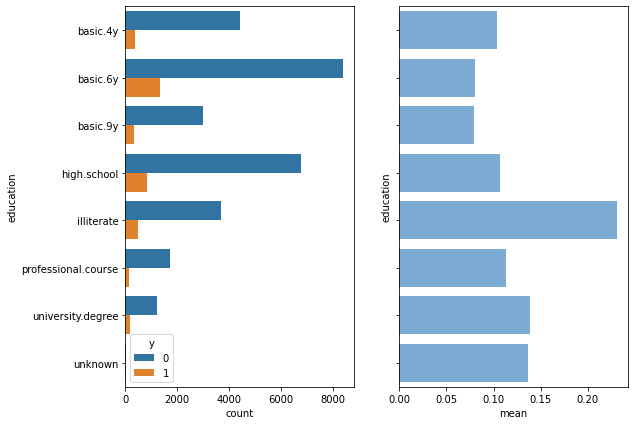

In [12]:
plot_cat(bank_train, "education")

(<AxesSubplot:xlabel='count', ylabel='default'>,
 <AxesSubplot:xlabel='mean', ylabel='default'>)

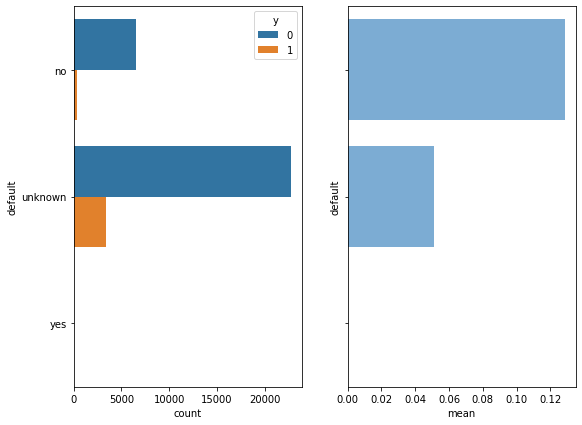

In [13]:
plot_cat(bank_train, "default")

(<AxesSubplot:xlabel='count', ylabel='housing'>,
 <AxesSubplot:xlabel='mean', ylabel='housing'>)

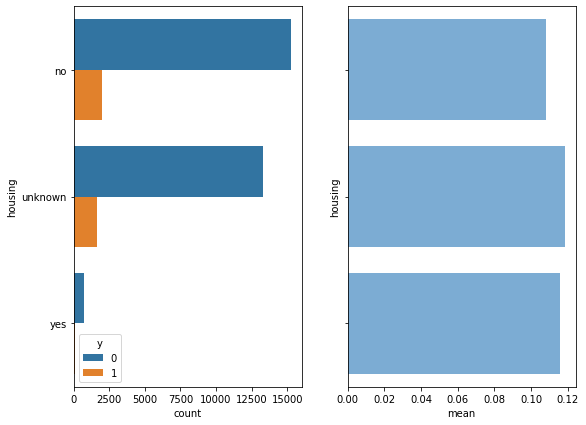

In [14]:
plot_cat(bank_train, "housing")

(<AxesSubplot:xlabel='count', ylabel='loan'>,
 <AxesSubplot:xlabel='mean', ylabel='loan'>)

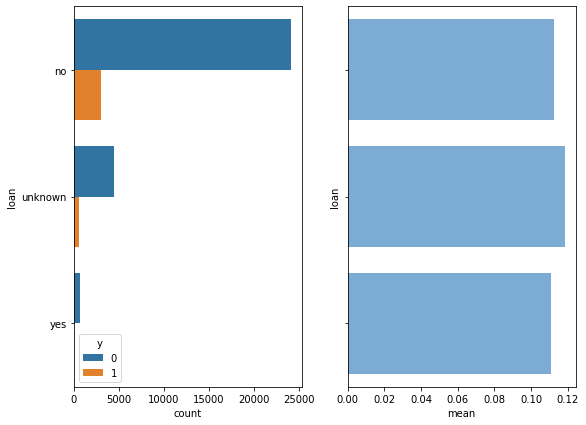

In [15]:
plot_cat(bank_train, "loan")

(<AxesSubplot:xlabel='count', ylabel='contact'>,
 <AxesSubplot:xlabel='mean', ylabel='contact'>)

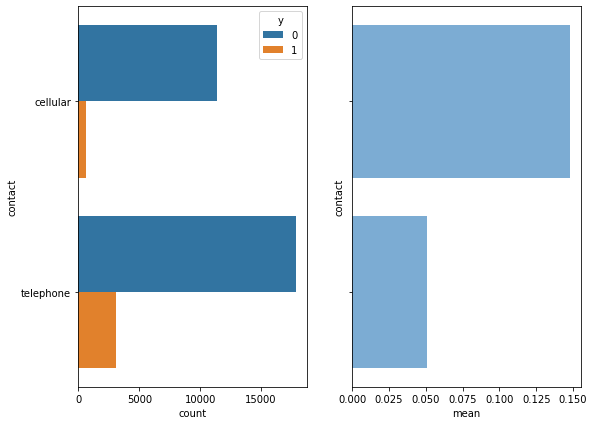

In [16]:
plot_cat(bank_train, "contact")

(<AxesSubplot:xlabel='count', ylabel='month'>,
 <AxesSubplot:xlabel='mean', ylabel='month'>)

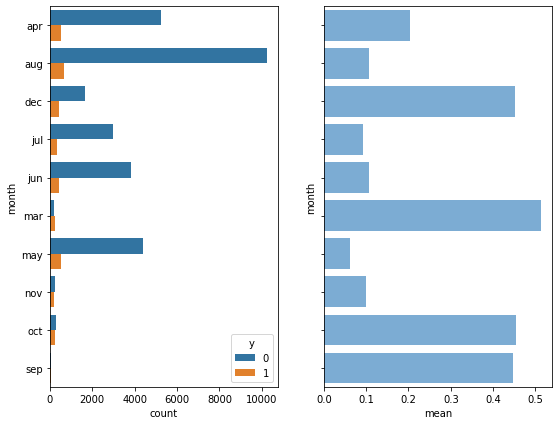

In [17]:
plot_cat(bank_train, "month")

(<AxesSubplot:xlabel='count', ylabel='day_of_week'>,
 <AxesSubplot:xlabel='mean', ylabel='day_of_week'>)

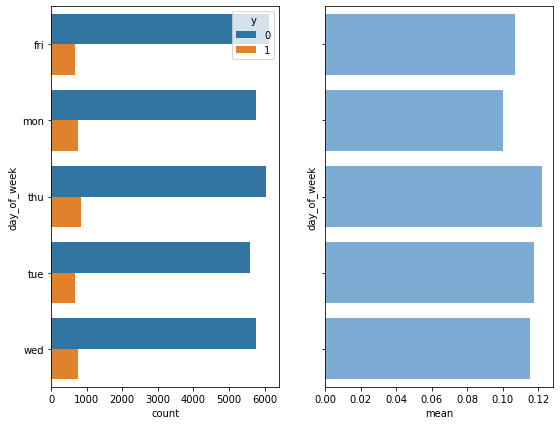

In [18]:
plot_cat(bank_train, "day_of_week")

(<AxesSubplot:xlabel='count', ylabel='poutcome'>,
 <AxesSubplot:xlabel='mean', ylabel='poutcome'>)

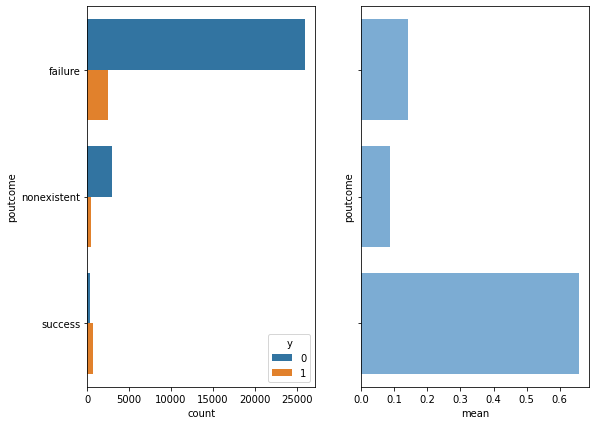

In [19]:
plot_cat(bank_train, "poutcome")

In [20]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 12556 to 15795
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32950 non-null  object 
 2   marital         32950 non-null  object 
 3   education       32950 non-null  object 
 4   default         32950 non-null  object 
 5   housing         32950 non-null  object 
 6   loan            32950 non-null  object 
 7   contact         32950 non-null  object 
 8   month           32950 non-null  object 
 9   day_of_week     32950 non-null  object 
 10  duration        32950 non-null  int64  
 11  campaign        32950 non-null  int64  
 12  pdays           32950 non-null  int64  
 13  previous        32950 non-null  int64  
 14  poutcome        32950 non-null  object 
 15  emp.var.rate    32950 non-null  float64
 16  cons.price.idx  32950 non-null  float64
 17  cons.conf.idx   32950 non-n

In [21]:
bank_train.groupby("y")[["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.914789,220.618123,2.641409,-0.894443,0.132501,0.250535,93.604539,-40.605560,3.813398,5176.281860
yes,40.827530,550.813495,2.032659,0.436437,0.492578,-1.238489,93.358157,-39.796383,2.117429,5094.571093


In [22]:
bank.groupby("y")["duration"].agg(["mean", "std"])

,mean,std
y,,
no,220.844807,207.096293
yes,553.191164,401.171871


<AxesSubplot:xlabel='age', ylabel='y'>

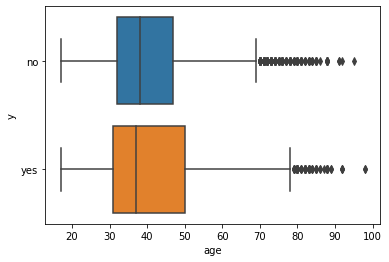

In [23]:
sns.boxplot(x="age", y="y", data=bank_train)

In [24]:
bank_train["y"].value_counts() / len(bank_train)

no     0.887557
yes    0.112443
Name: y, dtype: float64

In [27]:
bank_train["education"].value_counts()

university.degree      9750
high.school            7614
basic.9y               4808
professional.course    4176
basic.4y               3338
basic.6y               1852
unknown                1399
illiterate               13
Name: education, dtype: int64

C:\Users\silas\AppData\Local\Temp\ipykernel_9228\164900957.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  bank.hist(ax=ax)


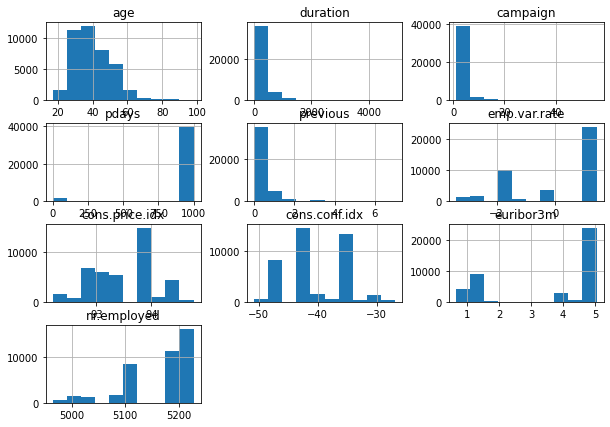

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
bank.hist(ax=ax)
plt.show()

In [107]:
from sklearn.base import BaseEstimator, TransformerMixin
# Transformers

class CombineEducation(BaseEstimator, TransformerMixin):
    def __init__(self, combine_basic=True):
        self.combine_basic = combine_basic
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if self.combine_basic:
            basic_edu = X[:, 3]
            X[:, 3] = np.where((basic_edu == "basic.4y") | (basic_edu == "basic.6y") | (basic_edu == "basic.9y"), "basic", basic_edu)
        return X

    
class ReplacePDays(BaseEstimator, TransformerMixin):
    def __init__(self, replace_to=-1):
        self.replace_to = replace_to
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        pdays = X[:, 12]
        X[:, 12] = np.where(pdays == 999, self.replace_to, pdays)
        return X

In [108]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [119]:
numeric_pipeline = Pipeline([
    ("repl_pdays", ReplacePDays())
])

cat_pipeline = Pipeline([
    ("comb_educ", CombineEducation())
])

In [120]:
teste = numeric_pipeline.fit_transform(bank_train)

In [123]:
teste[:, 12]

array([-1, -1, -1, ..., 4, -1, -1], dtype=object)

In [105]:
num_cols = ["age", "duration", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

In [114]:
teste = bank_train[num_cols]

In [117]:
list(teste)

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [99]:
edu = CombineEducation()

In [102]:
edu.transform(bank_train)[:, 3]

array(['basic', 'university.degree', 'basic', ..., 'high.school',
       'university.degree', 'university.degree'], dtype=object)

In [87]:
?isinstance

In [76]:
pdays_ = ReplacePDays()

In [101]:
pdays_.transform(bank_train)[:, 12]

InvalidIndexError: (slice(None, None, None), 12)

In [56]:
teste = bank_train.copy().values

In [61]:
teste[:, 3] = np.where((teste[:, 3] == "basic.4y") | (teste[:, 3] =="basic.9y"), "oi", teste[:, 3])

In [84]:
bank_train[:, 12]

InvalidIndexError: (slice(None, None, None), 12)